Source: This example comes from the torch adaptation of Charles Ollion [/github/charlesollion].

In [324]:
#Changeable prameters in the code
history = 25
drop_out_rate = 0.2
num_attention_head = 4
num_transformer_layer = 1
batch_size = 64

In [150]:
!pip install pandas_ta

In [247]:
#Load the libraries
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta

In [248]:
#mount the google drive to load the dataset from my drive
from google.colab import drive
drive.mount('/content/drive')

# download the data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSFT_2006-01-01_to_2018-01-01.csv", index_col='Date', parse_dates=['Date'])
print(data.shape[0])
# Adding indicators
# data['RSI']=ta.rsi(data.Close, length=15)
# data['EMAF']=ta.ema(data.Close, length=20)
# data['EMAM']=ta.ema(data.Close, length=100)
# data['EMAS']=ta.ema(data.Close, length=150)

# data['Target'] = data.Close-data.Open
# data['Target'] = data['Target'].shift(-1)

#data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetClose'] = data["Close"].shift(-1)

data.dropna(inplace=True)
data.reset_index(inplace = True)
data.drop(['Volume', 'Date','Name'], axis=1, inplace=True)
data.head(10)
print(data.shape[0])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
3019
3018


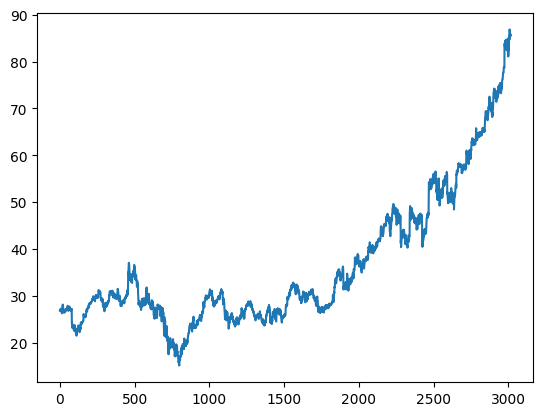

In [249]:
plt.plot(data['Close'])

In [203]:
data.head()

,Open,High,Low,Close,TargetClose
0,26.25,27.00,26.10,26.84,26.97
1,26.77,27.08,26.77,26.97,26.99
2,26.96,27.13,26.91,26.99,26.91
3,26.89,27.00,26.49,26.91,26.86
4,26.93,27.07,26.76,26.86,27.00


Data Acquisition

Data loading and preprocessing. Data is similar to project work, and has

In [250]:
#Function to convert the data to float
def floatation(df, attributes):
    for var in attributes:
        df[var] = df[var].astype(np.float32)     # converting the values into dot
    return df


In [251]:
df = data
attributes = list(df.columns)
df = floatation(df, attributes)
print(df.values)

[[26.25 27.   26.1  26.84 26.97]
 [26.77 27.08 26.77 26.97 26.99]
 [26.96 27.13 26.91 26.99 26.91]
 ...
 [85.31 85.53 85.03 85.4  85.71]
 [85.65 85.98 85.22 85.71 85.72]
 [85.9  85.93 85.55 85.72 85.54]]


In [252]:
data = df.to_numpy()

Function for splitting the dataset into sequences of observations of length history size.

In [253]:
def sequencing(dataset, start_index=0, end_index=None, history_size=history, step=1):
    data = []
    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)
    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])
    return np.array(data)


Function for splitting the dataset into training and validation, and data normalization.

In [208]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
def partition(data, pTrain=0.8, pVal = 0.4, save_path=None):
    # # I don't like this normalization before training thingie
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    data = (data - data_mean)/data_std
    stats = (data_mean, data_std)
    # sc = MinMaxScaler(feature_range=(0,1))
    # data = sc.fit_transform(data)


    sequencedData = sequencing(data, start_index=0, end_index=None, history_size=history, step=1)

    dataTrain, dataVal = train_test_split(sequencedData, train_size=pTrain, shuffle=False, random_state=123)
    dataVal, dataTest = train_test_split(dataVal, train_size=pVal, shuffle=False, random_state=123)

    return dataTrain, dataVal, dataTest

Create input-putput pairs.

In [209]:
def split(chunk):
    inputs = torch.tensor(chunk[:, :-1, :], device=device) # What about that device?
    targets = torch.tensor(chunk[:, 1:, :], device=device)
    return inputs, targets

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loaders

In [325]:
def createLoaders(dataTrain, dataVal, dataTest, batchSize=batch_size, responseVariables=4):
    XTrain, YTrain = split(dataTrain)
    XVal, YVal = split(dataVal)
    XTest, YTest = split(dataTest)

    indVars = [0,1,2,3]
    XTrain = XTrain[:,:, indVars]
    XVal = XVal[:,:, indVars]
    XTest = XTest[:,:, indVars]

    YTrain = YTrain[:,:,responseVariables]
    YVal = YVal[:,:,responseVariables]
    YTest = YTest[:,:,responseVariables]


    trainDS = torch.utils.data.TensorDataset(XTrain, YTrain)
    valDS = torch.utils.data.TensorDataset(XVal, YVal)
    testDS = torch.utils.data.TensorDataset(XTest, YTest)

    trainLoader = torch.utils.data.DataLoader(trainDS, batch_size=batchSize)
    valLoader = torch.utils.data.DataLoader(valDS, batch_size=batchSize)
    testLoader = torch.utils.data.DataLoader(testDS, batch_size=batchSize)

    #For plotting our results we want to keep the testing data batchless. Single big array
    # testLoader = torch.utils.data.DataLoader(testDS, batch_size=None)

    return trainLoader, valLoader, testLoader

trainData, valData, testData = partition(data)
trainDataset, valDataset, testDataset = createLoaders(trainData, valData, testData,responseVariables=4)


Transformer NN implementation

In [162]:
import torch.nn as nn
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, D, H):
        super(MultiHeadAttention, self).__init__()
        self.H = H # number of heads
        self.D = D # dimension

        self.wq = nn.Linear(D, D*H)
        self.wk = nn.Linear(D, D*H)
        self.wv = nn.Linear(D, D*H)

        self.dense = nn.Linear(D*H, D)

    def concat_heads(self, x):
        '''(B, H, S, D) => (B, S, D*H)'''
        B, H, S, D = x.shape
        x = x.permute((0, 2, 1, 3)).contiguous()  # (B, S, H, D)
        x = x.reshape((B, S, H*D))   # (B, S, D*H)
        return x

    def split_heads(self, x):
        '''(B, S, D*H) => (B, H, S, D)'''
        B, S, D_H = x.shape
        x = x.reshape(B, S, self.H, self.D)    # (B, S, H, D)
        x = x.permute((0, 2, 1, 3))  # (B, H, S, D)
        return x

    def forward(self, x, mask):

        q = self.wq(x)  # (B, S, D*H)
        k = self.wk(x)  # (B, S, D*H)
        v = self.wv(x)  # (B, S, D*H)

        q = self.split_heads(q)  # (B, H, S, D)
        k = self.split_heads(k)  # (B, H, S, D)
        v = self.split_heads(v)  # (B, H, S, D)

        attention_scores = torch.matmul(q, k.transpose(-1, -2)) #(B,H,S,S)
        attention_scores = attention_scores / math.sqrt(self.D)

        # add the mask to the scaled tensor.
        if mask is not None:
            attention_scores += (mask * -1e9)

        attention_weights = nn.Softmax(dim=-1)(attention_scores)
        scaled_attention = torch.matmul(attention_weights, v)  # (B, H, S, D)
        concat_attention = self.concat_heads(scaled_attention) # (B, S, D*H)
        output = self.dense(concat_attention)  # (B, S, D)

        return output, attention_weights

In [180]:
B, S, H, D = 18, 11, num_attention_head, 32
mha = MultiHeadAttention(D, H)
out, att = mha.forward(torch.zeros(B, S, D), mask=None)
out.shape, att.shape

(torch.Size([18, 11, 32]), torch.Size([18, 4, 11, 11]))

In [264]:
# Positional encodings
def get_angles(pos, i, D):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(D))
    return pos * angle_rates


def positional_encoding(D, position=20, dim=3, device=device):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(D)[np.newaxis, :],
                            D)
    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    if dim == 3:
        pos_encoding = angle_rads[np.newaxis, ...]
    elif dim == 4:
        pos_encoding = angle_rads[np.newaxis,np.newaxis,  ...]
    return torch.tensor(pos_encoding, device=device)

# function that implement the look_ahead mask for masking future time steps.
def create_look_ahead_mask(size, device=device):
    mask = torch.ones((size, size), device=device)
    mask = torch.triu(mask, diagonal=1)
    return mask  # (size, size)

create_look_ahead_mask(6)

class TransformerLayer(nn.Module):
    def __init__(self, D, H, hidden_mlp_dim, dropout_rate):
        super(TransformerLayer, self).__init__()
        self.dropout_rate = dropout_rate
        self.mlp_hidden = nn.Linear(D, hidden_mlp_dim)
        self.mlp_out = nn.Linear(hidden_mlp_dim, D)
        self.layernorm1 = nn.LayerNorm(D, eps=1e-9)
        self.layernorm2 = nn.LayerNorm(D, eps=1e-9)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.mha = MultiHeadAttention(D, H)


    def forward(self, x, look_ahead_mask):

        attn, attn_weights = self.mha(x, look_ahead_mask)  # (B, S, D)
        attn = self.dropout1(attn) # (B,S,D)
        attn = self.layernorm1(attn + x) # (B,S,D)

        mlp_act = torch.relu(self.mlp_hidden(attn))
        mlp_act = self.mlp_out(mlp_act)
        mlp_act = self.dropout2(mlp_act)

        output = self.layernorm2(mlp_act + attn)  # (B, S, D)

        return output, attn_weights

In [265]:
dl = TransformerLayer(16, 3, batch_size, drop_out_rate)
out, attn = dl(x=torch.zeros(5, 7, 16), look_ahead_mask=None)
out.shape, attn.shape

(torch.Size([5, 7, 16]), torch.Size([5, 3, 7, 7]))

In [166]:
class Transformer(nn.Module):
    '''Transformer Decoder Implementating several Decoder Layers.
    '''
    def __init__(self, num_layers, D, H, hidden_mlp_dim, inp_features, out_features, dropout_rate):
        super(Transformer, self).__init__()
        self.sqrt_D = torch.tensor(math.sqrt(D))
        self.num_layers = num_layers
        self.input_projection = nn.Linear(inp_features, D) # multivariate input
        self.output_projection = nn.Linear(D, out_features) # multivariate output
        self.pos_encoding = positional_encoding(D,position=history-1)
        self.dec_layers = nn.ModuleList([TransformerLayer(D, H, hidden_mlp_dim,
                                        dropout_rate=dropout_rate
                                       ) for _ in range(num_layers)])
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, mask):
        B, S, D = x.shape

        attention_weights = {}
        x = self.input_projection(x)
        x *= self.sqrt_D

        x += self.pos_encoding[:, :S, :]

        x = self.dropout(x)

        for i in range(self.num_layers):
            x, block = self.dec_layers[i](x=x,
                                          look_ahead_mask=mask)
            attention_weights['decoder_layer{}'.format(i + 1)] = block

        x = self.output_projection(x)

        return x, attention_weights # (B,S,S)

In [326]:
# Test Forward pass on the Transformer:
transformer = Transformer(num_layers=num_transformer_layer, D=32, H=1, hidden_mlp_dim=32,
                                       inp_features=4, out_features=1, dropout_rate=drop_out_rate)
transformer.to(device)
(inputs, targets) = next(iter(trainDataset))

S = inputs.shape[1]
mask = create_look_ahead_mask(S)
print(mask.shape)
print(inputs.shape)
out, attn = transformer (x=inputs, mask=mask)
out.shape, attn["decoder_layer1"].shape

torch.Size([24, 24])
torch.Size([64, 24, 4])


(torch.Size([64, 24, 1]), torch.Size([64, 1, 24, 24]))

Training the Transformer

In [327]:
param_sizes = [p.numel() for p in transformer.parameters()]
print(f"number of weight/biases matrices: {len(param_sizes)} "
      f"for a total of {np.sum(param_sizes)} parameters ")

number of weight/biases matrices: 20 for a total of 6657 parameters 


In [328]:
transformer = Transformer(num_layers=num_transformer_layer, D=32, H=num_attention_head, hidden_mlp_dim=32,
                          inp_features=4, out_features=1, dropout_rate=drop_out_rate).to(device)
optimizer = torch.optim.RMSprop(transformer.parameters(),
                                lr=0.00001)

In [329]:
!pip3 install tqdm
from tqdm import tqdm

n_epochs = 30
niter = len(trainDataset)
losses, val_losses = [], []

for e in tqdm(range(n_epochs)):

    # one epoch on train set
    transformer.train()
    sum_train_loss = 0.0
    for x,y in trainDataset:
        # assert y.shape == (32, 12, 1)
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        out = torch.squeeze(out)
        loss = torch.nn.MSELoss()(out, y)
        sum_train_loss += loss.item()
        loss.backward()
        optimizer.step()
    losses.append(sum_train_loss / niter)

    # Evaluate on val set
    transformer.eval()
    sum_val_loss = 0.0
    for i, (x, y) in enumerate(valDataset):
        S = x.shape[1]
        mask = create_look_ahead_mask(S)
        out, _ = transformer(x, mask)
        out = torch.squeeze(out)
        loss = torch.nn.MSELoss()(out, y)
        sum_val_loss += loss.item()
    val_losses.append(sum_val_loss / (i + 1))

100%|██████████| 30/30 [00:19<00:00,  1.58it/s]


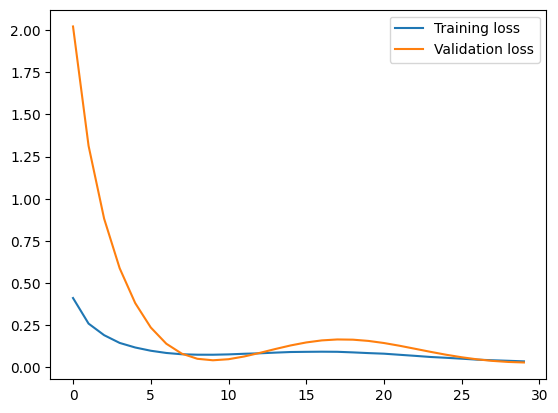

In [330]:
plt.plot(losses)
plt.plot(val_losses)
plt.legend(["Training loss", "Validation loss"], loc ="best")


In [334]:
# Evaluate on test set
test_losses = []

test_out = []
ground_truth = []
transformer.eval()
sum_val_loss = 0.0
test_losses = []

# Evaluate on val set
transformer.eval()
sum_val_loss = 0.0
for i, (x, y) in enumerate(testDataset):
    S = x.shape[1]
    mask = create_look_ahead_mask(S)
    out, _ = transformer(x, mask)
    out = torch.squeeze(out)
    loss = torch.nn.MSELoss()(out, y)
    sum_val_loss += loss.item()

     #Save test output
    out = torch.squeeze(out)[0]
    y = torch.squeeze(y)
    ground_truth.append(y[0].detach().numpy())
    test_out.append(out.detach().numpy())

test_losses.append(sum_val_loss / (i + 1))

[1.2684270702302456]


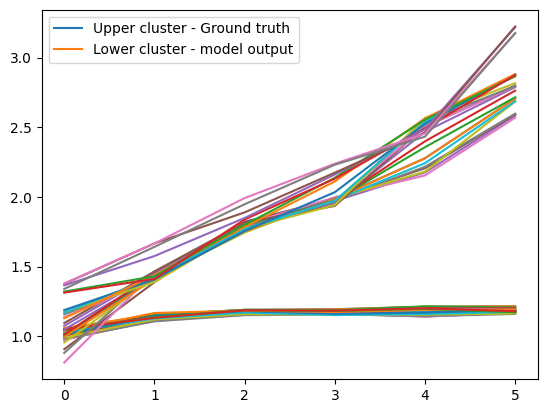

In [336]:
plt.plot(test_out)
plt.plot(ground_truth)
plt.legend(["Upper cluster - Ground truth","Lower cluster - model output"])
print(test_losses)

In [313]:
print(len(test_out))

6
